<span style='background:yellow'>**Question 3 (100 pt, each sub-question is 10 pt).**</span> 

Part A: Given Inetd dataset, an intrusion detection dataset that contains 2 columns. The first column represents a process ID number (PID) and the second column represents a system call. The goal is to extract the entire system call sequence by its PID, then tokenize and parse each sequence into 25-grams. After this, we’ll split the data into training and testing sets. Next, we ensure data quality in the training dataset by removing duplicate sequences within each class and overlapped sequences between both classes. To ensure a fair evaluation, we also clean the testing set by repeating the previous step. You will implement a Decision Tree model to train and test on the training set and testing set that we just clean. 


Part B: As the data type is sequential, we want to know how similar the sequences from both classes are and visualize how the similarity scores vary in different sequence lengths. Compute a cosine similarity score of 100 random pairs from both classes and get a median cosine similarity. Repeat this step in different sequence lengths (5, 10, 15, and 20). Plot a line chart to visualize how the median cosine similarities vary through sequence lengths of 5 to 25. 

You can download the datasets from github: https://github.com/unt-iialab/info5502-spring2022/tree/main/finalexam/q4


Step by step instructions and questions:

(1) Attached are the Normal and Intrusion data folders. Read in the data and store them in two separate dataframes. Combine the system calls (the second column) from the same PID (the first column) into a sequence or a string. 

(2) Parse an entire sequence into smaller sequences of size 25. (Hint: Use word_tokenize and ngrams from nltk library to parse).

(3) Add labels to the data, and partition the labeled data into training data and testing data with a ratio of 70/30.

(4) As the dataset has a lot of duplicate sequences, make sure that the testing data only contain unique sequences and that these sequences do not exist in the training data. Condense training data and testing data into two sets. Take the difference between the testing set and training set to remove the overlapped sequences from the testing data. 

(5) The sequences from each class can be repetitive, and some of these sequences may have different labels. Therefore, we need to remove the duplicate sequences within each class and the overlapped sequences from the Intrusion class. Start out by separating the Normal class and Intrusion class in the training data. Use the same concept in Question 4 to remove duplicate sequences and overlapped sequences from the training data.

(6) Repeat Question 5 to clean the testing data.

(7) Bootstrap the training data to get the same number of sequences from each class. Train and evaluate a Decision Tree model using the training data and testing data that we just clean. How is the performance?

(8) Randomly sample 100 pairs of sequences from both classes and calculate the median cosine similarity.

(9) Refer back to Question 2, parse the data into a length of 5, 10, 15, and 20. Clean the data from each class using Question 5. For each sequence length, calculate the median cosine similarity of 100 random pairs of sequences from both classes. 

(10) Plot a line chart to visualize how the median cosine similarities vary through different sequence lengths from 5 to 25.


In [29]:
# 1.)
import pandas as pd
import numpy as np

# load data from git
intr_data = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-intrusion.int", sep = " ", header = None)
norm_data = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-normal.int", sep = " ", header = None)

# setting column names
intr_data.columns = ['PID', 'SystemCalls']
norm_data.columns = ['PID', 'SystemCalls']

print(intr_data.head(2))
print()
print(norm_data.head(2))

   PID  SystemCalls
0  167           90
1  167          125

   PID  SystemCalls
0  167           90
1  167          125


In [30]:
print(intr_data.shape)
print(norm_data.shape)

(8371, 2)
(541, 2)


In [31]:
norm_data['PID'].value_counts()

2669    266
168     241
167      34
Name: PID, dtype: int64

In [32]:
intr_dict = {}
norm_dict = {}

# combining system calls
for pid in list(set(intr_data['PID'].values)):
    intr_dict[pid] = " ".join(str(value) for value in list(intr_data[intr_data['PID'] == pid]['SystemCalls'].values))

for pid in list(set(norm_data['PID'].values)):
    norm_dict[pid] = " ".join(str(value) for value in list(norm_data[norm_data['PID'] == pid]['SystemCalls'].values))

intr_dict[167]

'90 125 125 106 5 90 6 5 3 90 90 90 90 6 125 91 125 125 125 136 49 24 47 50 45 45 5 106 106 106 106 106 2 1'

In [33]:
import re
from nltk.util import ngrams
intr_list = []
norm_list = []

# generating ngrams with sequence length of 25

for key in intr_dict.keys():
    st = intr_dict[key]
    tkns = [token for token in st.split(" ") if token != ""]
    
    for ele in list(ngrams(tkns, 25)):
        intr_list.append(ele)
        
for key in norm_dict.keys():
    st = norm_dict[key]
    tkns = [token for token in st.split(" ") if token != ""]
    
    for ele in list(ngrams(tkns, 25)):
        norm_list.append(ele) 

print(len(intr_list))
print(len(norm_list))

7627
469


In [34]:
intr_df = pd.DataFrame(intr_list)
norm_df = pd.DataFrame(norm_list)

# adding labels to intrusion and normal data sequences
intr_df['class'] = 1
norm_df['class'] = 0

print(intr_df.shape)
print(norm_df.shape)

(7627, 26)
(469, 26)


In [35]:
comb_df = pd.DataFrame()

comb_df = comb_df.append(intr_df)
comb_df = comb_df.append(norm_df)

print(comb_df.shape)

(8096, 26)


In [36]:
# dropping duplicates...
comb_df = comb_df.drop_duplicates(subset = comb_df.columns[:-1], keep = 'last')
comb_df.shape

(333, 26)

In [37]:
comb_df['class'].value_counts()

1    177
0    156
Name: class, dtype: int64

In [38]:
comb_df.columns[:-1]

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24],
      dtype='object')

In [39]:
# building a decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# dropping target column
A = comb_df.drop("class", axis = 1)
B = comb_df['class']

# splitting dataset
A_train, A_valid, B_train, B_valid = train_test_split(A, B, test_size = 0.2, random_state = 0)
dt_classifier = DecisionTreeClassifier(max_depth = 10)
dt_classifier.fit(A_train, B_train)
B_pred = dt_classifier.predict(A_valid)
print(classification_report(B_valid, B_pred))



              precision    recall  f1-score   support

           0       0.76      0.86      0.81        22
           1       0.93      0.87      0.90        45

    accuracy                           0.87        67
   macro avg       0.84      0.87      0.85        67
weighted avg       0.87      0.87      0.87        67



In [40]:
import re
from nltk.util import ngrams
import pandas as pd

cosinesimilar_ngram = {}

for ngram in range(5, 26, 5):

    intr_data = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-intrusion.int", sep = " ", header = None)
    norm_data = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-normal.int", sep = " ", header = None)

    intr_data.columns = ['PID', 'SystemCalls']
    norm_data.columns = ['PID', 'SystemCalls']

    intr_dict = {}
    norm_dict = {}
    
    for pid in list(set(intr_data['PID'].values)):
        intr_dict[pid] = " ".join(str(value) for value in list(intr_data[intr_data['PID'] == pid]['SystemCalls'].values))

    for pid in list(set(norm_data['PID'].values)):
        norm_dict[pid] = " ".join(str(value) for value in list(norm_data[norm_data['PID'] == pid]['SystemCalls'].values))

    intr_list = []
    norm_list = []
    for key in intr_dict.keys():
        st = intr_dict[key]
        tkns = [token for token in st.split(" ") if token != ""]

        for ele in list(ngrams(tkns, ngram)):
            intr_list.append(ele)

    for key in norm_dict.keys():
        st = norm_dict[key]
        tkns = [token for token in s.split(" ") if token != ""]

        for ele in list(ngrams(tkns, ngram)):
            norm_list.append(ele)

    intr_df = pd.DataFrame(intr_list)
    norm_df = pd.DataFrame(norm_list)

    intr_df['class'] = 1
    norm_df['class'] = 0

    comb_df = pd.DataFrame()

    comb_df = comb_df.append(intr_df)
    comb_df = comb_df.append(norm_df)

    #print(combined_df.shape)
    #print()


    comb_df = comb_df.drop_duplicates(subset = comb_df.columns[:-1], keep = 'last')
    
    print()

    from sklearn.metrics.pairwise import cosine_similarity
    import statistics

    similar_list = []
    for i in range(0, 100):
        list1 = list(comb_df[comb_df['class'] == 0].sample(n = 1).iloc[0, :].values)
        list2 = list(comb_df[comb_df['class'] == 1].sample(n = 1).iloc[0, :].values)
        try:
            similar_list.append(cosine_similarity([list1], [list2]))
        except Exception as e:
            print(e)
            print(list1, list2)

    print(ngram, statistics.median(similar_list)[0][0])
    print()
    cosinesimilar_ngram[ngram] = statistics.median(similar_list)[0][0]



5 0.7028676896685275


10 0.6413172404134067


15 0.5812778982600045


20 0.5364008959966999


25 0.5020971057668311



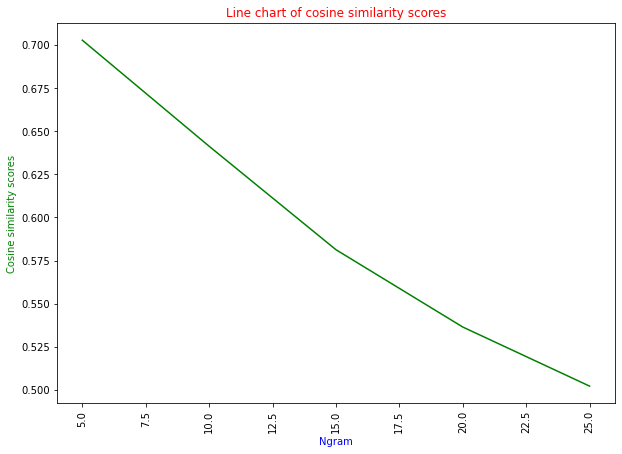

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# creating a dataframe of cosine similarity scores...
cosinesimilar_ngram_df = pd.DataFrame({"Ngram":list(cosinesimilar_ngram.keys()), "Similarityscores": list(cosinesimilar_ngram.values())})

# setting the figure parameters
plt.rcParams['figure.figsize'] = [10, 7]

# we iterate through each ngram range class and plot the cosine similarity value
sns.lineplot(x = "Ngram", y = "Similarityscores", data = cosinesimilar_ngram_df,color='green')
    
plt.title("Line chart of cosine similarity scores",color='red')
plt.xlabel("Ngram",color='blue')
plt.ylabel("Cosine similarity scores",color='green')
plt.xticks(rotation = 90)
plt.show()